In [8]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
# datascience version number of last run of this notebook
version.__version__

'0.5.10'

The following code that sets the random number seed should make our RNG results uniform instead of jumping around. But remember this probably needs to be rerun each time you rerun the RNG!

In [9]:
np.random.seed(seed=30716)

<h1>Class 6: Permutations and Confidence Intervals with Cat People</h1>

*Very special thanks to Kyle Nguyen, who wrote this exercise.*

<h3>"How different is that?"</h3>

When data is inherently messy, how different do things have to be before we say that the differences between them are *statistically significant*?

For example, suppose we ran a randomized controlled trial to examine the effect, $b$, of *eating breakfast*, $X$, on *body mass index*, $Y$. Formally, we can imagine $Y$ is a linear function of $X$:

$$Y = a + b X + \epsilon$$

and we'd like to estimate $b$.  When $X$ is a binary 0/1 treatment, we can compare the average $Y$ given $X = 1$ to the average $Y$ given $X = 0$, where $E[\cdot]$ is the *expectations operator* that produces the average:

$$b = E [Y \ | \ X = 1] - E[Y \ | \ X = 0]$$

Answering this question &mdash; how do we assess how big a $b$ is "big enough" &mdash; is critical for statistical inference!

There are at least two ways of doing this when we have data on $Y$ and $X$:
<ol>
<li>  Using the *bootstrap* &mdash; which is like rolling our dice a bunch of times and comparing what we see in the data to what randomness alone gets us &mdash; to estimate *standard errors* and *confidence intervals*
</li>

<li>  Using a combination of empirics and theory to estimate *standard errors* and *confidence intervals*
</li>
</ol>

In DS 8, you'll mostly use the bootstrap.  In other classes, and with other statistical packages other than Python, you may estimate standard errors instead. These methods are formally and computationally very different, but they are meant to answer the same question: "how different is that?"

Let's reexamine the HRS pets data from class 4.

<h2>Data source</h2>

As you may recall, the U.S. <a href="http://hrsonline.isr.umich.edu">Health and Retirement Study</a> (HRS) is a panel survey of thousands of Americans aged 50 and over and their spouses that is conducted biennially (every 2 years) starting in 1992.  In its 11th wave in 2012, a subsample of about 1,700 individuals were asked about <b>pet ownership</b>. 

In [10]:
#importing the data set that we will be using 
HRSpets = Table.read_table("http://demog.berkeley.edu/~redwards/Courses/LS88/c04_hrspets.csv")
HRSpets

hhidpn,age,sex,edyrs,health,anypets,numdogs,numcats,height,weight,bmi
1.0059e+07,84,1,17,2,0,0,0,1.905,89.3572,24.6
1.021e+07,73,1,6,5,0,0,0,1.6256,77.1103,29.2
1.0372e+07,76,2,10,3,0,0,0,1.4986,67.5849,30.1
1.0395e+07,74,2,15,5,1,1,0,1.7272,92.0788,30.9
1.0458e+07,68,2,16,4,1,0,1,1.6002,66.6777,26
1.0475e+07,81,2,17,3,0,0,0,1.524,41.2767,17.8
1.0648e+07,71,1,12,4,0,0,0,1.8034,68.0385,20.9
1.0773e+07,83,1,17,2,0,0,0,1.6764,63.5026,22.6
1.0818e+07,63,2,13,2,0,0,0,1.6383,70.3064,26.2
1.1141e+07,78,2,16,2,0,0,0,1.7526,74.8423,24.4


<h2>Formulate a question</h2>

There are many questions we can ask with data. Let's just pick one.  How about: "Do female respondents report owning more cats ($Y$) than males?"  Reformulating this, we might also say, "Is the average number of cats owned by female respondents, $E[Y \ | \ F = 1]$, greater than the average number of cats owned by male respondents, $E[Y \ | \ F = 0]$?"

Here I've defined the new female indicator variable $F =$ `sex` $- \ 1$, where our variable `sex` = 1 for males and 2 for females. At the end of this notebook, you'll see why this is useful.

<h2>How to formulate and complete a Hypothesis Test</h2>

Whenever you get a data set and are looking to draw a conclusion about something from the data set, you will be running a hypothesis test! In this example, we would like to determine whether or not there is an actual difference between the average number of cats owned by men and women. In order to come up with a conclusion, we will need these important pieces (taken from the Fall 2015 Data 8 Course):

<b>Null Hypothesis</b>: This says that the data were generated at random under clearly specified assumptions that make it possible to compute chances. The word "null" reinforces the idea that if the data look different from what the null hypothesis predicts, the difference is due to nothing but chance.

<b>Alternative Hypothesis</b>: This says that some reason other than chance made the data differ from what was predicted by the null hypothesis.

<b>Test Statistic</b>: In order to decide between the two hypothesis, we must choose a statistic upon which we will base our decision. This is called the test statistic. The test statistic can be anything you want it to be as long as it is repeatable.  

<b>P-value</b>: The P-value is the probability, under the null hypothesis, that the test statistic is equal to the value that was observed or is even further in the direction of the alternative. 

If your P-value is under 0.05, the observed test statistic is said to be statistically significant at the 5% level, a conventional level of significance. If your P-value is under 0.01, the observed test statistic is statistically significant at the 1% level. If you obtain a highly significant result, with a very low P-value, you can reject the null hypothesis in favor of the alternative hypothesis.  Recall that rejecting a "null" hypothesis means you're finding a pattern, typically a good thing!

The P-value and thus the choice between the null and alternative hypotheses depends on the comparison between the observed test statistic and its *simulated distribution* (basically the list of simulated values we will come up with) as predicted by the null hypothesis.

<font color="blue">Q1: State in words both (1) a good null hypothesis and (2) an alternative hypothesis regarding the number of cats reported by sex of the respondent.</font>

Since we are comparing the average number of cats owned by males and females, what do you think our test statistic should be? 

We will be taking the difference between the mean numbers of cats owned by males and females! 

*(Since the P-value is based on proportion of the value you get from the data set, we will not have to take the absolute value of the difference! That will actually skew our dataset set, by turning it into a one tailed test (making a P-value using only half of a normal distribution) rather than a two tailed test (the full normal distribution). This does not matter too much in the end, as you can always multiply a one tailed test value by 2 to turn it into a two tailed test value, we will not worry about this for now.)*

In the cell below, we will be solving for the test statistic of the empirical dataset. In order to solve for the test statistic, we will:
<ol>
<li>Find the average number of cats owned by males: $E[Y \ | \ F = 0]$
</li>

<li>Find the average number of cats owned by females: $E[Y \ | \ F = 1]$
</li>

<li>Find the difference. You can examine either male - female, or female - male, *as long as you keep the process consistent*
</li>
</ol>

<font color="blue">Q2: Select males from HRSpets using `.where()` remembering that `sex` == 1 for males, and create a new Table:</font>

In [11]:
Males = HRSpets.where('sex',1)

*(If you want to use `.mean()` from numpy on `Males`, that's cool. Otherwise, construct the mean manually as shown here.)*

<br>
<font color="blue">Q3: Calculate the number of males, for example using `len(Males.rows)`. This will be our denominator.</font>

In [12]:
num_males = len(Males.rows)
num_males

641

<font color="blue">Q4: Calculate the total number of cats owned by males using `sum()` and a call to `Males` and its appropriate column. This will be our numerator.</font>

In [13]:
total_cats_males = sum(Males['numcats'])
total_cats_males

204

<font color="blue">Q5: Now calculate the average number of cats owned by males, which equals the total number of cats owned by males divided by the number of males.</font>

In [14]:
avg_cats_males = total_cats_males / num_males
avg_cats_males 

0.31825273010920435

<font color="blue">Q6: Repeat this process for females.</font>

In [15]:
Females = HRSpets.where('sex',2)
num_females = len(Females.rows)
total_cats_females = sum(Females['numcats'])
avg_cats_females = total_cats_females / num_females
avg_cats_females

0.47768281101614435

<font color="blue">Q7: Construct the <b>test statistic</b>.  Let's measure the average number of cats among women minus the average number of cats among men: $E[Y \ | \ F = 1] - E[Y \ | \ F = 0]$</font>

In [16]:
diff_avg_cats = avg_cats_females - avg_cats_males
diff_avg_cats

0.15943008090694

<h3>Is this difference statistically significant?</h3>

Now that we have our test statistic, `diff_avg_cats`, how will we be able to tell whether or not it is statistically significant? 

According to the null hypothesis, the two variables are not related. If that were true, we could jumble around and play with the values all we want. If on the other hand they were related, then altering the values would alter the outcome.

*If it helps, think about the example from Class 5 with 4 dice. When we run the bootstrap, we're basically taking the dataset, tossing it up in the air like dice, and when things land randomly, we're seeing if things look the same or different from our original dataset.  If our dataset looks like 4 "boxcars" (i.e., number 6's), or like a real outlier, then we know something special is happening.  If it looks like two 3's and two 4's for 14, then we know it's not very special.*

<h4>Some terminology:</h4>
The process of resampling from the same data set with replacement is called the *bootstrap*.

The process of resampling from the same data set *without* replacement is called *permuting*.

You will see permutation and bootstrap tests many times in the class. For the purpose of the class, there isn't an enormous difference between the two;  you can use them interchangeably. That is because when you have a large sample size, the difference between sampling with and without replacement is close to negligible. 

Since we care only about gender and number of cats owned we will select only those columns for simplicity.

In [17]:
cat_ownership_data = HRSpets.select(['sex', 'numcats'])

Let's set `repetitions` to determine how many iterations to make. The more the better; 1,000 is a good round number.

And `diffs` stores the simulated test statistic which we will use later to compare to our empirical test statistic.

In [18]:
repetitions = 1000
diffs = []

Now for the guts of the bootstrap.

Let's write a `for`-loop that will loop through all `repetitions` 

In [19]:
for i in np.arange(repetitions):

    # Call .sample() to draw a random sample with replacement and call it "resample"
    
    resample = cat_ownership_data.sample(with_replacement=True)
    
    # Compute the difference of the means of the cat ownership between males and females
    # First, generate the mean for males
    male_ownership = resample.where('sex', 1)
    male_mean = sum(male_ownership['numcats']) / len(male_ownership.rows)
    
    # Then for females
    female_ownership = resample.where('sex', 2)
    female_mean = sum(female_ownership['numcats']) / len(female_ownership.rows)
    
    # Then compute the difference between the means
    diff_ownership = female_mean - male_mean
    
    #Finally, append to the list "diffs" the test statistic generated during this run
    diffs.append(diff_ownership)

diffs

[0.1970487334931153,
 0.19959534959249692,
 0.17797206131254617,
 0.21600789674478954,
 0.15002443443228686,
 0.044795865908710431,
 0.21242490413534687,
 0.18306345286204501,
 0.10250463821892397,
 0.11745720204994003,
 0.15929229761783065,
 0.055569358178053863,
 0.097396804800908232,
 0.19514432485322891,
 0.21147260273972601,
 0.2345977011494253,
 0.096602387511478427,
 0.057808359888410266,
 0.22584179237746133,
 0.24550669790352619,
 0.10986548437688504,
 0.25608488893778802,
 0.20363408521303261,
 0.14777390317087019,
 0.15448472499011023,
 0.22267042323806752,
 0.11549165120593691,
 0.2147654231993753,
 0.16628221301135337,
 0.13210724942039986,
 0.114957974942972,
 0.18829944002357796,
 0.19277360066833754,
 0.048133715225523843,
 0.16382046244521686,
 0.28019597845123823,
 0.172940957155783,
 0.16758115737473539,
 0.17794060501866393,
 0.074713161530606087,
 0.11411353646165984,
 0.063772918345631979,
 0.14977683646240919,
 0.18484186286949578,
 0.20687134502923982,
 0.123046

Now let's plot a histogram of these differences in the average number of cats by sex.

(array([   2.,   21.,   55.,  136.,  176.,  249.,  189.,  115.,   42.,   15.]),
 array([-0.01033026,  0.02094961,  0.05222948,  0.08350936,  0.11478923,
         0.14606911,  0.17734898,  0.20862885,  0.23990873,  0.2711886 ,
         0.30246847]),
 <a list of 10 Patch objects>)

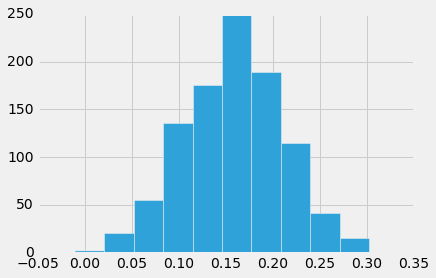

In [40]:
plots.hist(diffs)

<h3>The P-value</h3>

The P-value is the probability of obtaining a result like the sample test statistic &mdash; which in this case is the difference in the mean number of cats between men and women &mdash; under the null hypothesis.

Under the null hypothesis, there is no relationship between cat ownership and gender, so this difference should be zero: 

$$H_0: \ \ E[Y \ | \ F = 1] - E[Y \ | \ F = 0] = 0$$ 

So the P-value equals the proportion of our simulated, "toss-em-in-the-air" differences that are zero or "worse," in this case, negative.

In [21]:
p_value = np.count_nonzero(diffs < np.zeros(len(diffs)) ) / len(diffs)
p_value

0.001

When the P-value is very low, the probability of obtaining a result like our sample test statistic from randomness (the null hypothesis) is also very low. If it's low enough, commonly when it's under 0.05, we reject the null and conclude that the test statistic is *significantly different from zero*.

<h2>Other common methods</h2>

Another common way of assessing statistical significance is by constructing a *confidence interval* with the *standard error*.  

Recall the definition of the mean of $X$, often denoted $\bar{X}$ and also called the *expectation* of $X$, $E[X_i]$ (where we can write $i = 1, 2, ... N$ to index the $N$ observations we have of $X$):

$$\bar{X_i} \equiv E[X_i] = \frac{1}{N} \sum_i X_i$$

The <b>standard error of a mean</b>, or "SEM", is a function of the sample standard deviation, $STD$, of the underlying data, $X_i$, and the sample size, $N$.

$$SEM = \frac{STD[X_i]}{\sqrt{N}} = \frac{ \sqrt{ \frac{1}{N} \sum_i (X_i - E[X_i])^2 } }{\sqrt{N}}$$

<font color="blue">Q8: Calculate the standard error of the mean cats owned by males.</font> 

You will want to calculate the standard deviation of `Males['numcats']` and then divide by the square root of its length.
*(There is also a function in scipy.stats that does this directly.)*

In [22]:
SEM_males_numcats = Males['numcats'].std() / len(Males.rows)**0.5
SEM_males_numcats

0.035679975821773582

<font color="blue">Q9: Calculate the standard error of the mean cats owned by females.</font> 

In [23]:
SEM_females_numcats = Females['numcats'].std() / len(Females.rows)**0.5
SEM_females_numcats

0.038396713523280661

What now? A standard approach is to generate a 95% *confidence interval* around each mean.

A **confidence interval** is usually stated as either (a) a beginning number and an ending number, or (b) the midpoint number plus-or-minus half of the interval often called the "margin of error."

For example, the results of public opinion polls are often stated with a margin of error.  <a href="http://www.wbur.org/2016/02/25/wbur-poll-trump-clinton-sanders">A WBUR poll</a> of likely primary voters in Massachusetts prior to Super Tuesday 2016 provides a helpful example:

>Among [the $N = 418$ surveyed] likely Democratic voters, former Secretary of State Hillary Clinton is ahead of Vermont U.S. Sen. Bernie Sanders by 5 percentage points — 49-44 — just outside the survey’s 4.9 percent margin of error.


*(An aside: the eventual Super Tuesday result was <a href="http://www.nytimes.com/elections/results/massachusetts">Clinton with 50.1%</a>.)*

When the $Y$ variable that we're talking about is a dichotomous yes-or-no kind of question, then its mean is simply the share of "yes" answers, here $p = 0.49$, and the standard deviation equals $\sqrt{p\times(1-p)}$.

So our formula showing the standard error of the mean equal to the standard deviation of $Y$ divided by $\sqrt{N}$ implies that here, the standard error of the mean equals 

$$SEM_{y/n} = \sqrt{\frac{p\times(1-p)}{N}}$$

When $p = 0.49$ and $N = 418$, $SEM_{y/n} = $?

In [24]:
SEM = (0.49*(1-0.49)/418)**0.5
SEM

0.024450907753131645

<a href="https://en.wikipedia.org/wiki/1.96">From statistical theory and the great Ronald Fisher,</a> we know that 95% of the draws from a normal distribution will fall within **1.96** standard deviations of the mean. Thus a 95% confidence interval for an opinion poll like this is defined as $\pm 1.96 \times SEM_{y/n}$, here equal to what?

In [25]:
1.96*SEM

0.04792377919613802

*Wait a minute!!* Didn't the WBUR report state that the margin of error was 4.9%?  Try this math:

In [26]:
2*SEM

0.04890181550626329

In the real world, folks often just use 2 instead of 1.96 as the critical value, and you may see 2 instead of 1.96 in DS 8 as well.

<font color="blue">Q10: Calculate the *lower* 95% confidence interval of the mean cats owned by females, and compare it to the *upper* 95% confidence interval of the mean cats owned by males.</font> 

In [27]:
Females['numcats'].mean() - 1.96*SEM_females_numcats

0.40242525251051425

In [28]:
Males['numcats'].mean() + 1.96*SEM_males_numcats

0.38818548271988057

<font color="blue">Q11: Do these confidence interval overlap?</font>

If they do overlap, then we can't reject the hypothesis that males and females do not differ in their cat ownership. 

If the confidence intervals do NOT overlap, then we can reject the hypothesis that males and females do not differ.  Here, we would conclude that females report owning more cats.

<h3>Confidence Intervals and the Bootstrap</h3>

You can also calculate confidence intervals with the bootstrap results too. In order to solve for the confidence interval, find two percentiles from the list of the simulated values you created. Which two percentiles do you need? It depends on the level of confidence you want. 

In general, you will need to find the $\frac{c}{2}$ and $1 - \frac{c}{2}$ percentiles, where $c$ is a number like 0.10, 0.05, or 0.01. For example, if you were trying to find the 95% confidence interval, where $x = 0.05$, you'll want to find the 2.5 and 97.5 percentiles. 

In [29]:
# Find the confidence interval
low_bound_of_ci = np.percentile(diffs, 2.5)
high_bound_of_ci = np.percentile(diffs, 97.5)

# This is the 95% confidence interval of the test statistic
[low_bound_of_ci, high_bound_of_ci]

[0.054356586898198375, 0.26018296330421647]

<h3>Ordinary Least Squares Regression</h3>

Another very common and very flexible tool for hypothesis testing and creating confidence intervals is *ordinary least squares regression* or OLS. You will likely see this in DS 8 on Wednesday, March 9, 2016, but it's likely to be coded up from scratch, more or less.

Rather than step you through all the nuts and bolts of OLS, let's instead try to keep things simpler albeit more mysterious. OLS is a technique for estimating equations like:

$$Y = a + b X + \epsilon$$

Look familiar?

Here, let's set $Y = $ number of cats (`numcats`), and $X = 1$ if female. We could also set $X = sex$, which equals 1 for men and 2 for women, and our estimate and standard error of $b$ would be the same! 

In Python, the `stats.linregress(X,Y)` function from the `scipy` package allows us to estimate this equation and produce standard errors and P-values using empirics and theory. The arguments X and Y need to be of type `numpy.ndarray`. Columns of the Table `HRSpets` fulfill this requirement!

In [30]:
from scipy import stats

In [31]:
type(HRSpets['sex'])

numpy.ndarray

In [32]:
type(HRSpets['numcats'])

numpy.ndarray

In [39]:
slope, intercept, r_value, p_value, std_err = stats.linregress(HRSpets['sex']-[1],HRSpets['numcats'])
print(slope)
print(std_err)
print(p_value)
print("")
#print(intercept)

0.159430080907
0.0565742907197
0.00488756900363



<h1>Try It For Yourself! </h1>

Now it's your turn to try out writing a program to:
1. Run your own hypothesis test
2. Determine whether or not it is statistically significant
3. Create your own confidence interval.

Time permitting, let's split into workgroups and divvy up the following questions that we can answer with this dataset.  Go ahead and copy this code, copy the entire notebook if you like, and alter it to answer the question that you choose.

<br>
<font color="purple">Q1:  Are men aged 50 and over (in the HRS) taller or shorter than women?
</font>

&nbsp;

<font color="purple">Q2:  ("Crazy Dog Dudes") Is the number of dogs owned by men larger than the number of dogs owned by women?
</font>  

&nbsp;

<font color="purple">Q3:  Is health better for high school graduates (`edyrs` $\geq 12$)?
</font>  

&nbsp;

<font color="purple">Q4:  Is health better for college graduates (`edyrs` $\geq 16$)?
</font>  

*(Or choose another)*